<a href="https://colab.research.google.com/github/njucs/notebook/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Attention**
参考：\
https://wmathor.com/index.php/archives/1450/ \
https://wmathor.com/index.php/archives/1451/

#### 可视化

tensor([[-0.3802,  0.1057,  0.2663, -0.6036, -1.1020, -1.1005,  0.1153, -0.7060,
          2.0423,  1.4234,  0.9236, -0.3738,  0.9584, -0.2744, -0.8748, -1.5035,
          0.5673,  0.0726],
        [-0.5579,  0.8985, -0.5760,  1.5135, -2.1968, -0.0455,  0.8756,  1.6081,
          1.9654, -0.1541, -1.2582,  1.0514, -0.6922,  0.5173, -1.0673, -1.1837,
          0.4460,  0.1508],
        [ 1.2952, -0.0948,  0.5961, -0.4509, -0.1048,  0.4977,  1.8255, -1.1422,
         -0.3410,  1.2866, -0.6761, -0.5770,  0.8956,  1.7030,  1.4805,  0.4248,
          0.9538,  0.2951],
        [-0.7492,  0.8579,  0.5780,  0.6131, -0.5323, -0.5800,  0.3876,  0.9761,
         -0.3077,  1.6344, -0.8877,  1.4753, -1.0533, -1.9998, -0.0770,  0.1073,
         -0.3772,  0.0185],
        [-0.0941,  0.0306, -0.1978, -0.5577,  0.0539, -0.0443, -0.3901,  1.0827,
         -0.8696,  0.4439,  0.5666,  0.3521,  0.3688,  0.1132,  0.7450,  0.4552,
         -0.7735,  0.2189],
        [ 0.0306, -0.1846,  0.8665,  0.8362,  0.02

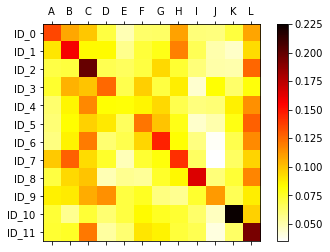

"\nnlp = spacy.load('en')    #import spacy，用于分词\nsent = nlp('Which NFL team represented the AFC at Super Bowl 50')  #对文章提一个问题\ndoc = open('F:/spacy.txt').read()\ndoc = nlp(doc)\n\ndata = []\nfor token1 in doc:\n     data.append([token1.similarity(token2) for token2 in sent])\n\nd = np.array(data)\nd = d.transpose()\ncol = [t.text for t in doc]     #需要显示的词\nindex = [t.text for t in sent]  #需要显示的词\ndf = pd.DataFrame(d, columns=col, index=index )\n\nfig = plt.figure()\n\nax = fig.add_subplot(111)\n\ncax = ax.matshow(df, interpolation='nearest', cmap='hot_r')\n#cax = ax.matshow(df)\nfig.colorbar(cax)\n\ntick_spacing = 1\nax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))\nax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))\n\n# fontdict = {'rotation': 'vertical'}    #设置文字旋转\nfontdict = {'rotation': 90}       #或者这样设置文字旋转\n#ax.set_xticklabels([''] + list(df.columns), rotation=90)  #或者直接设置到这里\n# Axes.set_xticklabels(labels, fontdict=None, minor=False, **kwargs)\nax.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

a = torch.randn(12, 18)
b = a.softmax(dim=1)
c = a.softmax(dim=0).transpose(0, 1)
print(a, '\n',  b, '\n', c)
d = b.matmul(c)
print(d)

d = d.numpy()

variables = ['A','B','C','D','E','F','G','H','I','J','K','L']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4','ID_5','ID_6','ID_7','ID_8','ID_9','ID_10','ID_11']

df = pd.DataFrame(d, columns=variables, index=labels)

fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(df, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)

tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_xticklabels([''] + list(df.columns))
ax.set_yticklabels([''] + list(df.index))

plt.show()

'''
nlp = spacy.load('en')    #import spacy，用于分词
sent = nlp('Which NFL team represented the AFC at Super Bowl 50')  #对文章提一个问题
doc = open('F:/spacy.txt').read()
doc = nlp(doc)

data = []
for token1 in doc:
     data.append([token1.similarity(token2) for token2 in sent])

d = np.array(data)
d = d.transpose()
col = [t.text for t in doc]     #需要显示的词
index = [t.text for t in sent]  #需要显示的词
df = pd.DataFrame(d, columns=col, index=index )

fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(df, interpolation='nearest', cmap='hot_r')
#cax = ax.matshow(df)
fig.colorbar(cax)

tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

# fontdict = {'rotation': 'vertical'}    #设置文字旋转
fontdict = {'rotation': 90}       #或者这样设置文字旋转
#ax.set_xticklabels([''] + list(df.columns), rotation=90)  #或者直接设置到这里
# Axes.set_xticklabels(labels, fontdict=None, minor=False, **kwargs)
ax.set_xticklabels([''] + list(df.columns), fontdict=fontdict)
ax.set_yticklabels([''] + list(df.index))

plt.show()
'''

# Seq2Seq with Attention 的 PyTorch 实现（机器翻译）

## Preparing Data

In [1]:
# !pip install -U torchtext

# 需要用老版本的torchtext，新版本的做了很多修改，本套代码需要修改的较多
!pip install torchtext==0.8.1

     |████████████████████████████████| 7.0 MB 9.7 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.7.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
#from torchtext.legacy.data import Field, BucketIterator
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

In [4]:
! python -m spacy download de
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

     |████████████████████████████████| 14.9 MB 13.0 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=3bd0ff0f1c2887853f78dc70f6c4e0a0682da6f44de11a30b0198a42951cb601
  Stored in directory: /tmp/pip-ephem-wheel-cache-5fkyyzoa/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


We create the tokenizers.

In [5]:
def tokenize_de(text):
    # Tokenizes German text from a string into a list of strings
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    # Tokenizes English text from a string into a list of strings
    return [tok.text for tok in spacy_en.tokenizer(text)]

The fields remain the same as before.

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


**加载数据。**输入的每个句子开头和结尾都带有特殊的标识符。对于每个 batch 内的句子，将它们的长度通过加 <PAD> 变得一样，即一个 batch 内的句子，长度都是相同的，不同 batch 内的句子长度不一定相同。

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),fields = (SRC, TRG))
# train_data, valid_data, test_data = Multi30k()

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 11.3MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.94MB/s]

downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.88MB/s]
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


**构建词库。**需要将源句子和目标句子分开构建字典，也就是单独对德语构建一个词库，对英语构建一个词库。

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Define the device.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [10]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Building the Seq2Seq Model

### Encoder



In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        # 获得embedding表示，input_dim是词典的大小尺寸，emb_dim是嵌入向量的维度
        # 建立了一个“二维表”，存储了词典中每个词的词向量
        # 每个mini-batch的训练，都要从词向量表找到mini-batch对应的单词的词向量作为RNN的输入放进网络。
        # nn.embedding的输入只能是编号，不能是隐藏变量，比如one-hot
        # embedding_dim的选择要合理，不能过度降维，如词典尺寸是1024，那么嵌入怎么也要15-20维左右（2^10=1024）
        self.embedding = nn.Embedding(input_dim, emb_dim) 
        
        # 双向单层GRU，输入的特征维度是emb_dim，输出的特征维度是enc_hid_dim
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True) 

        # 由于是双向GRU，最后的S0状态（decoder的输入信号）是enc_hid_dim * 2维
        # 因此通过一个全联接层转化为dec_hid_dim维才可以作为decoder输入
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src): 
        # 原始的src = [src_len, batch_size]
        # 交换0和1维的数据，src = [batch_size, src_len]
        src = src.transpose(0, 1)

        # nn.Embedding的输入形状为NxM（N是batch size,M是序列的长度），则输出的形状是N*M*embedding_dimension.
        # 输入必须是LongTensor，FloatTensor须通过tensor.long()方法转成LongTensor。
        # embedding输出为[batch_size, src_len, emb_dim]，交换前两维后变成[src_len, batch_size, emb_dim]
        embedded = self.dropout(self.embedding(src)).transpose(0, 1) # embedded = [src_len, batch_size, emb_dim]
        
        # CNN和RNN中输入的batchSize的默认位置是不同的：
        # CNN中batchsize的位置是position 0
        # RNN中batchsize的位置是position 1
        # RNN中可以用batch_first参数将输入的形式变为[batch_size, src_len, emb_dim]，此处没有设置
        # enc_output = [src_len, batch_size, hid_dim * num_directions]
        # enc_hidden = [n_layers * num_directions, batch_size, hid_dim]
        enc_output, enc_hidden = self.rnn(embedded) # if h_0 is not give, it will be set 0 acquiescently

        # enc_hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # enc_output are always from the last layer
        # enc_hidden [-2, :, : ] is the last of the forwards RNN 
        # enc_hidden [-1, :, : ] is the last of the backwards RNN
        # 需要的是 hidden 的最后一层输出（包括正向和反向）作为S0
        # 因此可以通过 hidden[-2,:,:] 和 hidden[-1,:,:] 取出最后一层的 hidden states
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        # s = [batch_size, dec_hid_dim]
        # 通过一个激活函数，增加非线性
        s = torch.tanh(self.fc(torch.cat((enc_hidden[-2,:,:], enc_hidden[-1,:,:]), dim = 1)))
        
        return enc_output, s

### Attention


In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        # 注意力就是通过一个align函数，获得enc_output的每一个输出h_t，与S_i的相关性alpha_i
        # 在原论文中，这个align函数的设计，需要两个线性层，即下面的attn和v
        # 通过attn和v后得到的相关性并没有进行归一化，最终还要经过Softmax做归一化得到最终的注意力

        # 第二个参数dec_hid_dim其实可以是任何值，只是将相关性变成一维数值的中间过渡表示
        # 将Encoder的输出enc_output和s拼接，最终嵌入向量的维度是enc_hid_dim*2+dec_hid_dim
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim, bias=False)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, s, enc_output):
        
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim * 2]
        
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        
        # s的维度无法与enc_output拼接，因此要将s转化为[batch_size, src_len, dec_hid_dim]
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, dec_hid_dim]
        # enc_output = [batch_size, src_len, enc_hid_dim * 2]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        
        # 通过激活函数增加非线性（似乎每次通过中间的线性层后，都会加一个激活函数增加非线性）
        # energy = [batch_size, src_len, dec_hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim = 2)))
        
        # 再通过一个线性层后，得到未归一化的相关性
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        
        # 归一化后得到最终的相关性（注意力）
        return F.softmax(attention, dim=1)

### Decoder


In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim # 输入维度是output_dim（TRG词表大小尺寸）
        self.attention = attention # 注意力是在decoder中计算的，所以要将attention传入

        # 针对decoder中输入的y_i，获得其embedding
        self.embedding = nn.Embedding(output_dim, emb_dim) # 获得embedding表示
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, dec_input, s, enc_output):
             
        # 获得dec_input的embedding，*** 注意：获得embedding后一般都会做一个dropout，防止过拟合！ ***
        # dec_input = [batch_size]，输入的是单个词
        # s = [batch_size, dec_hid_dim]
        # enc_output = [src_len, batch_size, enc_hid_dim * 2]
        dec_input = dec_input.unsqueeze(1) # dec_input = [batch_size, 1]
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1) # embedded = [1, batch_size, emb_dim]
        
        # 获得s与enc_output之间的归一化相关性（注意力）
        # a = [batch_size, 1, src_len]  
        a = self.attention(s, enc_output).unsqueeze(1)
        
        # enc_output = [batch_size, src_len, enc_hid_dim * 2]
        enc_output = enc_output.transpose(0, 1)

        # 基于注意力（相关性），与enc_output做加权求和，作为当前状态的context（c），后续再基于c、s、y生成下一状态的s
        # 实际上考虑到了所有时刻的enc_output（h_i），只不过对于某些时刻可能关注的更多，而某些时刻关注的更少，这就是注意力机制
        # torch.bmm 是针对 batch 做相乘（即同一个 batch 内的矩阵相乘），结果是[batch_size, 1, enc_hid_dim * 2]
        # c = [1, batch_size, enc_hid_dim * 2]
        c = torch.bmm(a, enc_output).transpose(0, 1)

        # 由于 GRU 只需要两个变量，所以要将embedded（y）和c整合一下
        # rnn_input = [1, batch_size, (enc_hid_dim * 2) + emb_dim]
        rnn_input = torch.cat((embedded, c), dim = 2)
            
        # dec_output = [src_len(=1), batch_size, dec_hid_dim]，因为当前只预测出一个状态，rnn_input和s都是[1, batch_size, ?]
        # dec_hidden = [n_layers * num_directions, batch_size, dec_hid_dim]
        # s = [batch_size, dec_hid_dim]，所以应该先将其拓展一个维度
        dec_output, dec_hidden = self.rnn(rnn_input, s.unsqueeze(0))
        
        # 最后需要将三个变量全部拼接在一起，然后通过一个全连接神经网络，得到最终的预测，所以维度要调整一致
        # embedded = [batch_size, emb_dim]
        # dec_output = [batch_size, dec_hid_dim]
        # c = [batch_size, enc_hid_dim * 2]
        embedded = embedded.squeeze(0)
        dec_output = dec_output.squeeze(0)
        c = c.squeeze(0)
        
        # 实际上就是为了转换维度，因为需要的输出是 TRG_VOCAB_SIZE 大小
        # 也可以理解为最后就是基于embedded（y）、c（注意力下的context）和s（dec_output）分类，目标类别数就是 TRG_VOCAB_SIZE 大小
        # pred = [batch_size, output_dim]
        # 此处的 pred 给出的是在整个 TRG_VOCAB_SIZE 上的分类结果，存储在 output_dim 中，使用时要再通过 argmax 取出最大的结果
        pred = self.fc_out(torch.cat((dec_output, c, embedded), dim = 1))
        
        # 【疑问】如果是多层或者双向RNN，dec_hidden = [n_layers * num_directions, batch_size, dec_hid_dim]怎么做squeeze(0)？
        return pred, dec_hidden.squeeze(0)

### Seq2Seq


In [14]:
# 用来利用encoder-decoder模型获得一组输出
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # 低于阈值则用ground truth作为下一个输入，否则用预测结果作为下一个输入
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # enc_output is all hidden states of the input sequence, back and forwards
        # s is the final forward and backward hidden states, passed through a linear layer
        # enc_output = [src_len, batch_size, hid_dim * num_directions]
        # s = [batch_size, dec_hid_dim]
        enc_output, s = self.encoder(src)
                
        # first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert dec_input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            # 此处的s在不断更新，新的attention是在decoder中计算，所以要把enc_output传入
            # dec_output = [batch_size, output_dim]
            # s = [batch_size, dec_hid_dim]
            dec_output, s = self.decoder(dec_input, s, enc_output)
            
            # 对预测的每个结果做记录，output[t] = [batch_size, trg_vocab_size]，即[batch_size, output_dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = dec_output
            
            # decide if we are going to use teacher forcing or not
            # 这里是一种简化的方法，即随机一定概率使用teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 通过 argmax 返回指定维度最大值的序号，即预测结果中可能性最大的词在词典中的索引
            # get the highest predicted token from our predictions
            top1 = dec_output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            # 实际情况时表示可以在这里判断dec_output中最大概率是不是超过某个阈值来决定是否使用teacher forcing
            dec_input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# ignore_index=TRG_PAD_IDX，这个参数的作用是忽略某一类别，不计算其 loss
# 因为 PAD 是为了补齐句子长度加入的占位符，没有必要对其进行损失的计算
# 要注意，忽略的是真实值中的类别，而不是根据预测值的情况进行忽略
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

We then create the training loop...

In [16]:
'''
model.train() 和 model.eval() 的作用是什么：
1. 设置了训练或者测试模式，定义模型是否需要学习，对部分层有影响，如 Dropout 和 BatchNormal
2. Dropout 在训练时，是启用的，有 p% 的几率丢弃神经元，但在测试过程中，不需要去丢弃神经元
3. BatchNormal 在训练过程中，模型每次处理一个 minibatch 数据，会根据一个 minibatch 来计算
   mean 和 std 后做归一化处理，这也是为什么模型的性能和minibatch的大小关系很大。
   测试时，BatchNormal 会利用训练时得到的参数来处理测试数据
4. model. train()和model. eval()可以看做是对这种训练和测试需要联动的模块进行一个统一的设置。
   当你在写model的时候，你写的是测试和训练通用的model，这个时候，就是通过model. train()和
   model. eval()来来设置model的测试阶段和训练阶段。这样在用需要训练和测试联动的模块的时候，
   就不用再专门写一个训练的model和一个测试的model了

模型中没有 dropout 和 BatchNormal 时，可以不用设置 model.train() 和 model.eval()。
'''

def train(model, iterator, optimizer, criterion):
    model.train()    
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src # src = [src_len, batch_size]
        trg = batch.trg # trg = [trg_len, batch_size]

        # pred = [trg_len, batch_size, pred_dim]，其中 pred_dim 就是 trg_vocab_size
        pred = model(src, trg)
        
        pred_dim = pred.shape[-1]
        
        # trg = [(trg len - 1) * batch size]
        # pred = [(trg len - 1) * batch size, pred_dim]
        trg = trg[1:].view(-1)
        pred = pred[1:].view(-1, pred_dim)
        
        # trg 相当于就是 label， pred 是 outputs
        loss = criterion(pred, trg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
  
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [17]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    # 测试阶段不需要更新梯度
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg # trg = [trg_len, batch_size]

            # output = [trg_len, batch_size, output_dim]
            output = model(src, trg, 0) # turn off teacher forcing
          
            output_dim = output.shape[-1]
            
            # trg = [(trg_len - 1) * batch_size]
            # output = [(trg_len - 1) * batch_size, output_dim]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

Finally, define a timing function.

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [19]:
# 正无穷
best_valid_loss = float('inf')

for epoch in range(10):
    # 训练过程开始计时
    start_time = time.time()
    
    # 训练+验证
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    # 训练过程结束计时
    end_time = time.time()
    # 计算训练用时
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # 存储最佳模型
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 2m 53s
	Train Loss: 4.347 | Train PPL:  77.210
	 Val. Loss: 3.631 |  Val. PPL:  37.768
Epoch: 02 | Time: 2m 53s
	Train Loss: 3.114 | Train PPL:  22.502
	 Val. Loss: 3.319 |  Val. PPL:  27.626
Epoch: 03 | Time: 2m 53s
	Train Loss: 2.653 | Train PPL:  14.193
	 Val. Loss: 3.316 |  Val. PPL:  27.553
Epoch: 04 | Time: 2m 53s
	Train Loss: 2.355 | Train PPL:  10.535
	 Val. Loss: 3.254 |  Val. PPL:  25.892
Epoch: 05 | Time: 2m 52s
	Train Loss: 2.136 | Train PPL:   8.465
	 Val. Loss: 3.278 |  Val. PPL:  26.531
Epoch: 06 | Time: 2m 54s
	Train Loss: 1.994 | Train PPL:   7.348
	 Val. Loss: 3.300 |  Val. PPL:  27.123
Epoch: 07 | Time: 2m 52s
	Train Loss: 1.884 | Train PPL:   6.581
	 Val. Loss: 3.306 |  Val. PPL:  27.288
Epoch: 08 | Time: 2m 52s
	Train Loss: 1.777 | Train PPL:   5.915
	 Val. Loss: 3.295 |  Val. PPL:  26.985
Epoch: 09 | Time: 2m 53s
	Train Loss: 1.694 | Train PPL:   5.442
	 Val. Loss: 3.384 |  Val. PPL:  29.501
Epoch: 10 | Time: 2m 52s
	Train Loss: 1.651 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [20]:
# 加载最佳模型
model.load_state_dict(torch.load('tut3-model.pt'))

# 评估在测试集上的性能
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


| Test Loss: 3.339 | Test PPL:  28.184 |


In [ ]:
import matplotlib.pyplot as plt
# Show Attention
# ...............
plt.show()

# **一个简化的例子**（但没太看懂……）

In [ ]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
# [seq_len, batch_size]，一个 batch 内的句子，长度都是相同的，不同 batch 内的句子长度不一定相同

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        # enc_outputs 指的是所有时刻的最后一层隐藏状态, enc_hidden 指的是最后一个时刻所有隐藏层的状态
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    # 实际操作中，在数据预处理的时候，需要将源句子和目标句子分开构建字典
    # 也就是单独对源语言构建一个词库，对目标语言构建一个词库
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()